## Import Data

## Removing Data

In [1]:
#Setup Gdrive file download extention 
!pip install gdown

In [2]:
# !gdown --id <File ID>
!gdown --id 19VRQQ7hA-gq8SNznga2IY2cfZuLBOkkk

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19VRQQ7hA-gq8SNznga2IY2cfZuLBOkkk
From (redirected): https://drive.google.com/uc?id=19VRQQ7hA-gq8SNznga2IY2cfZuLBOkkk&confirm=t&uuid=ca4b5a8d-4654-4ec4-a49d-e418323c2854
To: /kaggle/working/dataset_new.zip
100%|██████████████████████████████████████| 1.23G/1.23G [00:12<00:00, 98.6MB/s]


In [4]:
!unzip 'dataset_new.zip'

Archive:  dataset_new.zip
  inflating: dataset_new/test/Melanocytic/ISIC_0000129_downsampled.jpg  
  inflating: dataset_new/test/Melanocytic/ISIC_0000135_downsampled.jpg  
  inflating: dataset_new/test/Melanocytic/ISIC_0000118_downsampled.jpg  
  inflating: dataset_new/test/Melanocytic/ISIC_0000210.jpg  
  inflating: dataset_new/test/Melanocytic/ISIC_0000133_downsampled.jpg  
  inflating: dataset_new/test/Melanocytic/ISIC_0000237.jpg  
  inflating: dataset_new/test/Melanocytic/ISIC_0000134_downsampled.jpg  
  inflating: dataset_new/test/Melanocytic/ISIC_0000255.jpg  
  inflating: dataset_new/test/Melanocytic/ISIC_0000212.jpg  
  inflating: dataset_new/test/Melanocytic/ISIC_0000252.jpg  
  inflating: dataset_new/test/Melanocytic/ISIC_0000231.jpg  
  inflating: dataset_new/test/Melanocytic/ISIC_0000258.jpg  
  inflating: dataset_new/test/Melanocytic/ISIC_0000045_downsampled.jpg  
  inflating: dataset_new/test/Melanocytic/ISIC_0000253.jpg  
  inflating: dataset_new/test/Melanocytic/ISIC_0

In [5]:
#  Model
import tensorflow as tf
# Reading Images
import numpy as np
import os, cv2
import re, random
import matplotlib.pyplot as plt
import seaborn as sns
from keras.applications import VGG16
# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Define tand get the number os devices. 
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 2


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(0.2),
])



batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.

  if shuffle:
    ds = ds.shuffle(1000)
  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x),y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

augmented_train_dataset = prepare(train_dataset,augment= True)
augmented_val_dataset = prepare(val_dataset,augment= True)
augmented_test_dataset = prepare(test_dataset, augment=True)

In [ ]:
# Show augmented images
image_batch, label_batch = next(iter(augmented_train_dataset))
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title(np.argmax(label_batch[i]))
  plt.axis("off")

In [11]:
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

# model_performance(VGG16_history, 30)

In [12]:
def model_evaluation(model, train_dataset, val_dataset, test_dataset):
    train_score = model.evaluate(train_dataset, verbose= 1)
    valid_score = model.evaluate(val_dataset, verbose= 1)
    test_score = model.evaluate(test_dataset, verbose= 1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

# model_evaluation(VGG16_model, augmented_train_dataset,augmented_val_dataset,augmented_test_dataset)


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools


predictions = VGG16_model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)


y_true = []
for _, labels in test_dataset:
  y_true.extend(np.argmax(labels.numpy(), axis=1))


cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


# Get class names from the dataset
class_names = test_dataset.class_names

# Plot the confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix for Skin Disease Classification')
plt.show()

In [ ]:
import keras
keras.saving.save_model(VGG16_model, 'my_model_7.keras')
# model.save_weights('my_model_weights.h5')

## Mixed New Dataset

In [6]:
import os
import shutil

def merge_datasets(train_dir, test_dir, output_dir):
  """Merges the training and testing datasets into a single output directory.

  Args:
    train_dir: The directory containing the training data.
    test_dir: The directory containing the testing data.
    output_dir: The directory where the merged dataset will be saved.
  """

  if not os.path.exists(output_dir):
    os.makedirs(output_dir)

  for class_name in os.listdir(train_dir):
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    output_class_dir = os.path.join(output_dir, class_name)

    if os.path.isdir(train_class_dir):
      if not os.path.exists(output_class_dir):
        os.makedirs(output_class_dir)

      for filename in os.listdir(train_class_dir):
        src = os.path.join(train_class_dir, filename)
        dest = os.path.join(output_class_dir, filename)
        shutil.copy(src, dest)

      if os.path.isdir(test_class_dir):
        for filename in os.listdir(test_class_dir):
          src = os.path.join(test_class_dir, filename)
          dest = os.path.join(output_class_dir, filename)
          shutil.copy(src, dest)


# Example usage:
train_data_dir = './dataset_new/train'
test_data_dir = './dataset_new/test'
merged_data_dir = './dataset_new/merged'

merge_datasets(train_data_dir, test_data_dir, merged_data_dir)

In [19]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(merged_data_dir,
                                                                    shuffle=True,
                                                                    label_mode='categorical',
                                                                    batch_size=64,
                                                                    interpolation='bicubic',
                                                                    validation_split=0.4,
                                                                    subset='both',
                                                                    image_size=(224, 224),
                                                                    seed=123)
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take((val_batches) // 2)
val_dataset = val_dataset.skip((val_batches) // 2)

Found 10493 files belonging to 9 classes.
Using 6296 files for training.
Using 4197 files for validation.


In [22]:
import tensorflow as tf
from keras import layers
from keras import regularizers
base_model = VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3), pooling= 'max')

for layer in base_model.layers[:10]:
    layer.trainable = False
    

inputs = tf.keras.Input(shape=(224, 224, 3))
scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)
x = base_model(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu',  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5))(x)
x = tf.keras.layers.Dropout(0.2)(x)  
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
x = tf.keras.layers.Dense(32, activation = 'relu')(x)
predictions = tf.keras.layers.Dense(9, activation = "softmax")(x)   
# the model
VGG16_model= tf.keras.Model(inputs = inputs, outputs = predictions)
VGG16_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
VGG16_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,152,201 (57.80 MB)

 Trainable params: 13,416,713 (51.18 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [ ]:
epochs = 50   

VGG16_history = VGG16_model.fit(train_dataset, epochs= epochs, verbose=1, validation_data=val_dataset, shuffle= False)

Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 71s 676ms/step - accuracy: 0.1393 - loss: 2.6425 - val_accuracy: 0.1823 - val_loss: 2.5266
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 57s 573ms/step - accuracy: 0.1460 - loss: 2.5324 - val_accuracy: 0.2163 - val_loss: 2.4948
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 55s 557ms/step - accuracy: 0.1791 - loss: 2.5065 - val_accuracy: 0.2388 - val_loss: 2.4684
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 56s 562ms/step - accuracy: 0.2100 - loss: 2.4791 - val_accuracy: 0.2422 - val_loss: 2.4381
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 56s 563ms/step - accuracy: 0.2318 - loss: 2.4487 - val_accuracy: 0.2499 - val_loss: 2.3982
Epoch 6/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 56s 566ms/step - accuracy: 0.2533 - loss: 2.4096 - val_accuracy: 0.2528 - val_loss: 2.3553
Epoch 7/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 56s 564ms/step - accuracy: 0.2507 - loss: 2.3657 - val_accuracy: 0.2528 - val_loss: 2.3080
Epoch 8/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 56s 561ms/step - accuracy: 0.2571 - loss: 2.3208 - val_accu

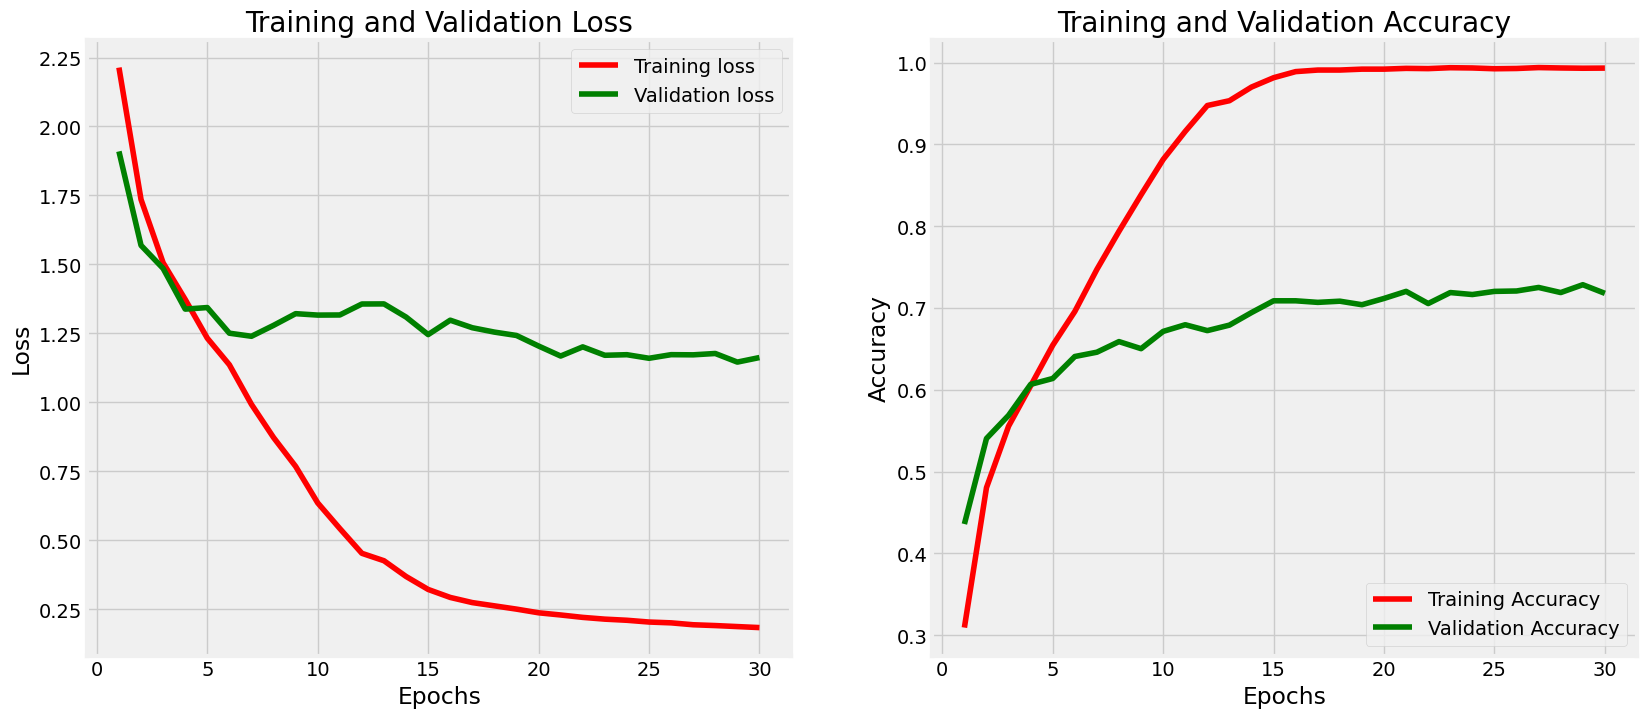

In [13]:
model_performance(VGG16_history, 50)

In [14]:
model_evaluation(VGG16_model, train_dataset, val_dataset, test_dataset)

99/99 ━━━━━━━━━━━━━━━━━━━━ 31s 311ms/step - accuracy: 0.9943 - loss: 0.1802
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 300ms/step - accuracy: 0.7047 - loss: 1.2330
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step - accuracy: 0.6889 - loss: 1.2323
Train Loss:  0.17759793996810913
Train Accuracy:  0.9960291981697083
--------------------
Validation Loss:  1.16251802444458
Validation Accuracy:  0.7179856300354004
--------------------
Test Loss:  1.2435743808746338
Test Accuracy:  0.6946022510528564


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

predictions = VGG16_model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)

y_true = []
for _, labels in test_dataset:
  y_true.extend(np.argmax(labels.numpy(), axis=1))

cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix for Skin Disease Classification')
plt.show()

In [ ]:
# prompt: save model
import keras
# Save the entire model as a SavedModel.
keras.saving.save_model(VGG16_model, 'model_fix_regularized_3.keras')
# Alternatively, you can save only the model's weights.
VGG16_model.save_weights('model_fix_regularized_3.weights.h5')